In [87]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [88]:
df = pd.read_csv('../clean_data/data_completed_model.csv')

In [89]:
features = [
    'likes_per_content_weekly_change',
    'followers_weekly_change',
    'comments_per_likes_weekly_change',
    'comments_per_likes_ma_2',
    'comments_per_likes_ma_3',
    'change_followers_ma_3',
    'comments_per_likes_ma_5',
    'change_followers_ma_5'
]
df['comments_per_likes_weekly_change'].replace([float('inf'), float('-inf')], 0, inplace=True)

In [90]:
# Standardize the data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

In [91]:
# Isolation Forest
iso_forest = IsolationForest(contamination=0.05)
df['iso_forest'] = iso_forest.fit_predict(X_scaled)

In [92]:
# One-Class SVM
oc_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma=0.1)
df['one_class_svm'] = oc_svm.fit_predict(X_scaled)

In [93]:
# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df['lof'] = lof.fit_predict(X_scaled)

In [94]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['followers', 'pictures', 'videos', 'comments', 'likes']])

# Initialize DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Convert labels: -1 remains for outliers, all others become 1 for 'normal'
df['dbscan'] = np.where(dbscan_labels == -1, -1, 1)

# Check the updated column
print(df['dbscan'].value_counts())

 1    27532
-1     2757
Name: dbscan, dtype: int64


# Autoencoder
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(14, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
df['autoencoder'] = mse

In [95]:
# unique values per algorithm column: 'iso_forest', 'one_class_svm', 'lof', 'dbscan'
algo_cols = ['iso_forest', 'one_class_svm', 'lof', 'dbscan']
for col in algo_cols:
    print(f'Unique values for {col}: {df[col].unique()}')

Unique values for iso_forest: [-1  1]
Unique values for one_class_svm: [-1  1]
Unique values for lof: [ 1 -1]
Unique values for dbscan: [ 1 -1]


In [104]:
# percentage of anomalies (at least one algorithm detected as anomaly: contains -1) over all data
df['anomaly'] = np.where(df[algo_cols].sum(axis=1) < 0, -1, 1)
print(f'Anomaly percentage: {df["anomaly"].value_counts(normalize=True)}')

Anomaly percentage:  1    0.939982
-1    0.060018
Name: anomaly, dtype: float64


In [105]:
# percentage of anomalies (at least 2 algorithms detected as anomaly: contains -1) over all data
df['anomaly'] = np.where(df[algo_cols].sum(axis=1) < -1, -1, 1)
print(f'Anomaly percentage: {df["anomaly"].value_counts(normalize=True)}')

Anomaly percentage:  1    0.939982
-1    0.060018
Name: anomaly, dtype: float64


In [ ]:
# 0.25    4301
# 0.75    2191
# 0.50    1295
# 1.00     358
# Name: agreement, dtype: int64

# compute the normalzed agreement on the value counts
df['agreement'].value_counts(normalize=True) 

0.25    0.762422
0.50    0.177560
0.75    0.057524
1.00    0.002493
Name: agreement, dtype: float64

In [97]:
# drop rows without any outliers: all values are 1
df = df[(df[algo_cols] != 1).any(axis=1)]

In [98]:
# add percentage of agreenment column 
df['agreement'] = df[['iso_forest', 'one_class_svm', 'lof', 'dbscan']].apply(lambda x: np.mean(x == -1), axis=1)

<Axes: ylabel='Frequency'>

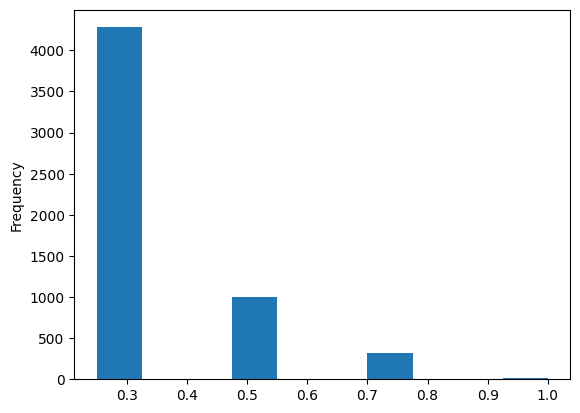

In [99]:
# plot percentage of agreement
df['agreement'].plot.hist()

In [100]:
# are there any rows with 100% agreement?
print(df['agreement'].value_counts())

0.25    4281
0.50     997
0.75     323
1.00      14
Name: agreement, dtype: int64


In [101]:
# 0.25    4301
# 0.75    2191
# 0.50    1295
# 1.00     358
# Name: agreement, dtype: int64

# compute the normalzed agreement on the value counts
df['agreement'].value_counts(normalize=True) 

0.25    0.762422
0.50    0.177560
0.75    0.057524
1.00    0.002493
Name: agreement, dtype: float64